### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import os
import re

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, regexp_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
stopwords_list = stopwords.words('english')
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer

### Load Data

We are primarily going to work with only the training data. This data consists of 14438 observations, which should be plenty for a suitable model. The label for the type of diagnosis is only present in the training data. Furthermore, we can test our testing data on our model at the end, but we will not be able to validate its performance.

In [3]:
filepath = r"C:\Users\tscofield\Documents\Git\Capstone3-MedicalSentimentAnalysis\Data\Text_data\train.txt"

train_data = pd.read_table(filepath, delimiter = '\t', names = ['idx', 'text'])
train_dic = {'text': train_data['text']} # Soilik testua behar dugu
train_data = pd.DataFrame(train_dic)

train_data.head()

,text
0,Catheterization laboratory events and hospital...
1,Renal abscess in children. Three cases of rena...
2,Hyperplastic polyps seen at sigmoidoscopy are ...
3,Subclavian artery to innominate vein fistula a...
4,Effect of local inhibition of gamma-aminobutyr...


Now, we need to get the labels for the diagnosis type from the text. We will need to do a few steps to get the labels: 1) use readlines(), and regular expressions (RegEx) to parse the labels from the text. Here, we can do that by separating objects that are digits followed by a tab.

In [4]:
# create a list of the lines of text
with open(filepath) as f:
    contents = f.readlines()

In [5]:
#find all digits followed by tab
tab_digits = r"\d+\\t"
labels_raw = re.findall(tab_digits, str(contents))

digits = r"\d+"
labels = re.findall(digits, str(labels_raw))

# add new column to data
train_data['label'] = labels

# convert to integer and zero-index labels
train_data['label'] = train_data['label'].astype(str).astype(int) - 1

print("Number of observations: " + str(len(train_data)))
train_data.head()

Number of observations: 14438


,text,label
0,Catheterization laboratory events and hospital...,3
1,Renal abscess in children. Three cases of rena...,4
2,Hyperplastic polyps seen at sigmoidoscopy are ...,1
3,Subclavian artery to innominate vein fistula a...,4
4,Effect of local inhibition of gamma-aminobutyr...,3


Labels diagnosis description:

0: neoplasms

1: digestive system diseases

2: nervous system diseases

3: cardiovascular diseases

4: general pathological conditions

### EDA

For NLP projects, there is not an abundance of EDA work. One of the only beneficial things we can do is investigate our response variable, labels, a bit further.

In [5]:
# count label values
train_data['label'].value_counts()

4    4805
0    3163
3    3051
2    1925
1    1494
Name: label, dtype: int64

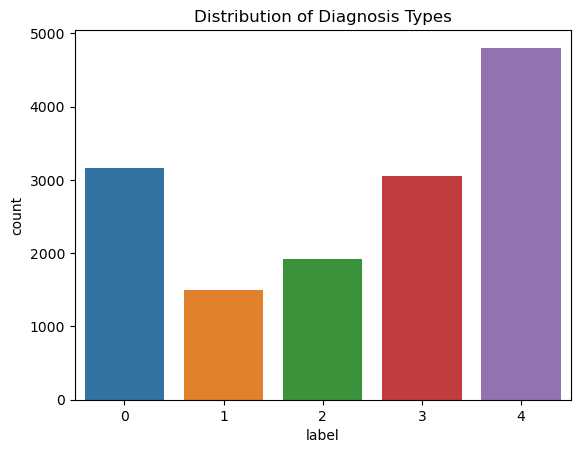

In [6]:
sns.countplot(data=train_data, x='label')
plt.title('Distribution of Diagnosis Types')
plt.show()

We can see from the plot that the most frequent diagnosis is a general pathological condition. However, there is not a large class imbalance in the data, so we shouldn't need to take many special precautions in the modeling stage. The least frequent diagnosis are digestive system diseases. General pathological conditions outweigh digestive system diseases by 4805:1494 or approximately 3.2:1. 

### Feature Engineering

To understand as much as possible from the diagnosis text, I am going to extract several numerical features from each observation. These will be values such as character count, word count, sentence count, stopword count, and ratio of unique words vs word count. Then, we can test our models with and without the added features to determine their value in classification. 

In [6]:
# create functions for added features

def count_chars(text):
    return len(text)

def count_words(text):
    return len(text.split())

def count_capital_words(text):
    return sum(map(str.isupper,text.split()))

def count_words_in_quotes(text):
    #regex = r"'.'|".""
    regex = r'"(.+?)"'
    x = re.findall(regex, text)
    count=0
    if x is None:
        return 0
    else:
        for i in x:
            t=i[1:-1]
            count+=count_words(t)
        return count
    
def count_sent(text):
    return len(nltk.sent_tokenize(text))    

def count_unique_words(text):
    return len(set(text.split()))

def count_stopwords(text):
    stop_words = set(stopwords.words('english'))  
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)

In [7]:
# compute the functions above for all observations
train_data['char_count'] = train_data['text'].apply(lambda x:count_chars(x))
train_data['word_count'] = train_data['text'].apply(lambda x:count_words(x))
train_data['capital_word_count'] = train_data['text'].apply(lambda x:count_capital_words(x))
train_data['quoted_word_count'] = train_data['text'].apply(lambda x:count_words_in_quotes(x))
train_data['sent_count'] = train_data['text'].apply(lambda x:count_sent(x))
train_data['unique_word_count'] = train_data['text'].apply(lambda x:count_unique_words(x))
train_data['stopword_count'] = train_data['text'].apply(lambda x:count_stopwords(x))

# add additional features for ratios and average values
train_data['avg_wordlength'] = train_data['char_count']/train_data['word_count']
train_data['avg_sentlength'] = train_data['word_count']/train_data['sent_count']
train_data['unique_vs_words'] = train_data['unique_word_count']/train_data['word_count']
train_data['stopwords_vs_words'] = train_data['stopword_count']/train_data['word_count']

In [10]:
# view the updated data
train_data.head()

,text,label,char_count,word_count,capital_word_count,quoted_word_count,sent_count,unique_word_count,stopword_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words
0,Catheterization laboratory events and hospital...,3,1687,234,0,0,5,108,51,7.209402,46.800000,0.461538,0.217949
1,Renal abscess in children. Three cases of rena...,4,963,147,2,0,9,102,47,6.551020,16.333333,0.693878,0.319728
2,Hyperplastic polyps seen at sigmoidoscopy are ...,1,1032,142,0,0,11,85,47,7.267606,12.909091,0.598592,0.330986
3,Subclavian artery to innominate vein fistula a...,4,871,131,0,0,8,93,52,6.648855,16.375000,0.709924,0.396947
4,Effect of local inhibition of gamma-aminobutyr...,3,2012,275,9,0,9,157,84,7.316364,30.555556,0.570909,0.305455


In [11]:
# view summary statistics for numerical features
train_data.describe()

,label,char_count,word_count,capital_word_count,quoted_word_count,sent_count,unique_word_count,stopword_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words
count,14438.000000,14438.000000,14438.000000,14438.000000,14438.000000,14438.000000,14438.000000,14438.000000,14438.000000,14438.000000,14438.000000,14438.000000
mean,2.335296,1230.665120,179.937110,4.334118,0.150921,8.597451,110.390428,58.939881,6.903394,20.965579,0.640972,0.329108
std,1.552432,507.347695,76.549766,6.065470,1.792640,3.277289,38.882009,25.562224,0.454317,5.355089,0.086457,0.043156
min,0.000000,170.000000,24.000000,0.000000,0.000000,2.000000,20.000000,6.000000,5.500000,6.800000,0.340502,0.168539
25%,1.000000,850.000000,122.000000,0.000000,0.000000,6.000000,82.000000,40.000000,6.590442,17.200000,0.581011,0.300885
50%,3.000000,1210.000000,176.000000,2.000000,0.000000,8.000000,110.000000,58.000000,6.874424,20.400000,0.635922,0.329167
75%,4.000000,1589.000000,235.000000,6.000000,0.000000,11.000000,138.000000,76.000000,7.183137,24.000000,0.695652,0.357832
max,4.000000,3999.000000,596.000000,68.000000,120.000000,27.000000,282.000000,198.000000,9.326923,57.666667,0.965517,0.492147


From the summary statistics, we can see that there are going to be some outliers in the added numerical features. For example, some diagnosis text is going to be a lot longer than others (e.g. 3999 characters vs. 170 characters). However, we are not going to remove outliers from this data as this all seems sensible. 

### Text Preprocessing

Now, I want to preprocess the text to tokenize, lowercase, remove stopwords, position tag, extract word type (noun, adverb, etc.), and lemmatize. I will also compute a Tf-idf vectorizer in the modeling stage as I want to parameter test the "max-features" variable and its effect on the models.  

In [8]:
# define wordnet tags function. This will be used to assign word type
def wordnet_tags(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [9]:
# this function streamlines the text preprocessing
def prepare_doc(doc, stopwords=stopwords_list):
    # tokenize text
    regex_tokenizer = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_tokenizer.tokenize(doc)
    
    # lowercase
    doc = [x.lower() for x in doc]
    
    # remove stopwords
    doc = [x for x in doc if x not in stopwords_list]
    
    # position tag
    doc = pos_tag(doc)
    doc = [(x[0], wordnet_tags(x[1])) for x in doc]
    
    # assign word type
    noun_count = 0
    adj_count = 0
    verb_count = 0
    adv_count = 0
    for i in range(len(doc)):
        noun_count += doc[i].count('n')
        adj_count += doc[i].count('a')
        verb_count += doc[i].count('v')
        adv_count += doc[i].count('r')
    
    # lemmatizing
    lemma = WordNetLemmatizer() 
    doc = [lemma.lemmatize(x[0], x[1]) for x in doc]
    
    return ' '.join(doc), noun_count, adj_count, verb_count, adv_count

In [49]:
# run text data through prepare_doc and fill word type arrays
X = train_data['text']
noun_count = []
adj_count = []
verb_count = []
adv_count = []
X_text = []
for x in X:
    text, n_count, j_count, v_count, r_count = prepare_doc(x, stopwords_list)
    noun_count.append(n_count)
    adj_count.append(j_count)
    verb_count.append(v_count)
    adv_count.append(r_count)
    X_text.append(text)
    
y = train_data['label']

In [50]:
# add word type features to data
train_data['noun_count'] = noun_count
train_data['adj_count'] = adj_count
train_data['verb_count'] = verb_count
train_data['adv_count'] = adv_count

In [12]:
# create new df for only added features
train_features = train_data.drop(['text', 'label'], axis=1)
train_features.head()

,char_count,word_count,capital_word_count,quoted_word_count,sent_count,unique_word_count,stopword_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words,noun_count,adj_count,verb_count,adv_count
0,1687,234,0,0,5,108,51,7.209402,46.800000,0.461538,0.217949,88,47,19,9
1,963,147,2,0,9,102,47,6.551020,16.333333,0.693878,0.319728,43,20,17,6
2,1032,142,0,0,11,85,47,7.267606,12.909091,0.598592,0.330986,35,24,19,1
3,871,131,0,0,8,93,52,6.648855,16.375000,0.709924,0.396947,38,23,10,5
4,2012,275,9,0,9,157,84,7.316364,30.555556,0.570909,0.305455,98,45,31,11


In [53]:
np.shape(X_text)

(14438,)

In [52]:
vectorizer = TfidfVectorizer(max_features=500)
train_tf_idf_features = vectorizer.fit_transform(X_text).toarray()
train_tf_idf = pd.DataFrame(train_tf_idf_features)
np.shape(train_tf_idf)

(14438, 500)

### Save Data

Now, I am going to save the two dataframes to be used in the modeling stage. I am saving them separately because I want to test model performance with and without the added features.

In [36]:
# save train_features
train_features.to_csv("train_features.csv")

In [37]:
# save train labels
y = pd.DataFrame(y, columns=['label'])
y.to_csv("train_labels.csv")

Now, all the text data has been processed, we have added many additional features to hopefully improve classification results, and we have saved the dataframes to be used in the modeling notebook.